# Results comparisson

This notebook uses the output from clasiffy_df.ipynb and creates tables and plots to compare models

### Imports

In [7]:
import os
import sys
import itertools

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

### Definitions

In [8]:
sys.path.insert(0, "../../")
from config import RESULTS_PATH

# Paths
RESULTS_FOLDER = os.path.join(RESULTS_PATH, 'evaluated')

# Configuration
# Remove effect of incopmplete tags (just for testing the classifiers)
REMOVE_MISSING_LABELS = True  # Set this to true to remove all entities not asssociated to a manually tagged instance
REMOVE_MISSING_SAM = True

### Generate table

In [9]:
rows = list()

for model in os.listdir(RESULTS_FOLDER):
    
    model_preds = list()
    coco_labels = list()
    for test in os.listdir(os.path.join(RESULTS_FOLDER,model)):
        if '.csv' in test:
            this_test = pd.read_csv(os.path.join(RESULTS_FOLDER,model, test))

            if REMOVE_MISSING_SAM:
                this_test = this_test.loc[this_test['cell_id_sam']>=0]
            if REMOVE_MISSING_LABELS:
                this_test = this_test.loc[this_test['cell_id_coco']>=0]

            this_test = this_test.sort_values(by=['cell_id_coco', 'is_cell_sam'], ascending=[True, False])
            this_test['has_cell_sam_1_before'] = this_test.groupby('cell_id_coco')['is_cell_sam'].cumsum() > 0
            this_test = this_test[~((this_test['is_cell_sam'] == 0) & this_test['has_cell_sam_1_before'])]
            this_test = this_test.drop(columns=['has_cell_sam_1_before'])
            
            model_preds += this_test['is_cell_sam'].values.tolist()
            coco_labels +=  this_test['is_cell_ground_truth'].values.tolist()


    model_preds = np.array(model_preds).astype(int)
    coco_labels = np.array(coco_labels).astype(int)
    if "AutoEncoder" in model:
        model_preds = 1-model_preds
    print(f"{model} -- True Rate: {model_preds.sum()/(len(model_preds)):0.2f}")        

    rows.append([model, 
                 accuracy_score(coco_labels, model_preds), 
                 precision_score(coco_labels, model_preds), 
                 recall_score(coco_labels, model_preds), 
                 confusion_matrix(coco_labels, model_preds) # tn, fp, fn, tp
                 ])

results = pd.DataFrame(rows, columns=['model', 
                                      'accuracy_score', 
                                      'precision_score', 
                                      'recall_score', 
                                      'confusion_matrix'])
results = results.sort_values('recall_score', ascending=False).reset_index(drop=True)


supervised_Encoder_SSIM+MAE0 -- True Rate: 0.78
supervised_Encoder_SSIM+MAE2 -- True Rate: 0.66
supervised_Encoder_SSIM+MAE1 -- True Rate: 0.76
supervised_Encoder_SSIM+MAE3 -- True Rate: 0.66
supervised_Encoder_SSIM+MAE4 -- True Rate: 0.88


In [10]:
results

,model,accuracy_score,precision_score,recall_score,confusion_matrix
0,supervised_Encoder_SSIM+MAE4,0.884888,1.0,0.884888,"[[0, 0], [374, 2875]]"
1,supervised_Encoder_SSIM+MAE0,0.778530,1.0,0.778530,"[[0, 0], [720, 2531]]"
2,supervised_Encoder_SSIM+MAE1,0.759482,1.0,0.759482,"[[0, 0], [780, 2463]]"
3,supervised_Encoder_SSIM+MAE2,0.661792,1.0,0.661792,"[[0, 0], [1110, 2172]]"
4,supervised_Encoder_SSIM+MAE3,0.659478,1.0,0.659478,"[[0, 0], [1121, 2171]]"


### Generate plots

In [11]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    # From documentation of scypy and wikipedia
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    # https://en.wikipedia.org/wiki/Confusion_matrix
    # We need to re-rder the matrix
    tn, fp, fn, tp = cm.ravel()

    cm = np.array([[tp, fn],[fp, tn]])

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm, 0)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

/tmp/ipykernel_48678/2877191624.py:11: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


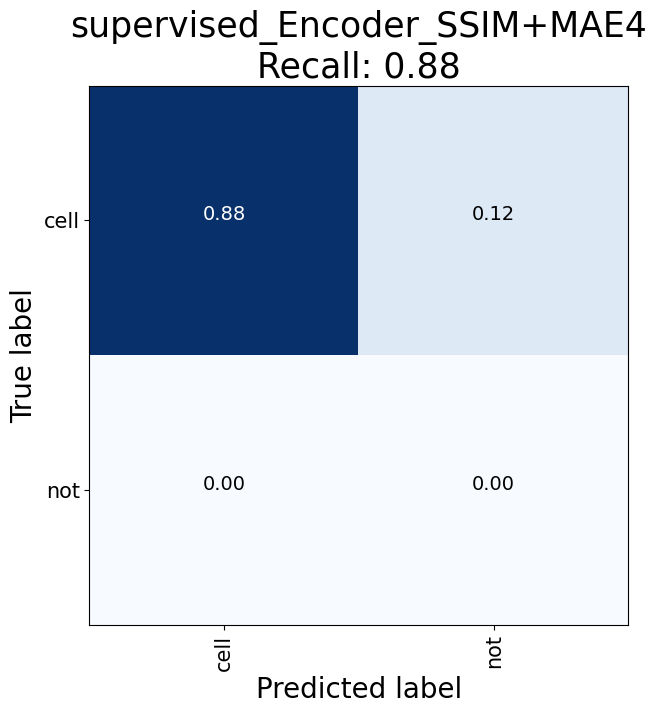

/tmp/ipykernel_48678/2877191624.py:11: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


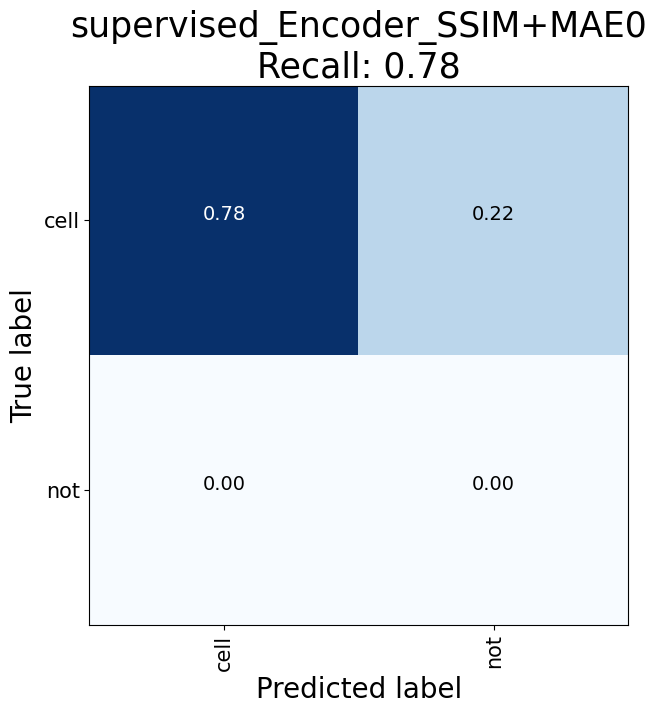

/tmp/ipykernel_48678/2877191624.py:11: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


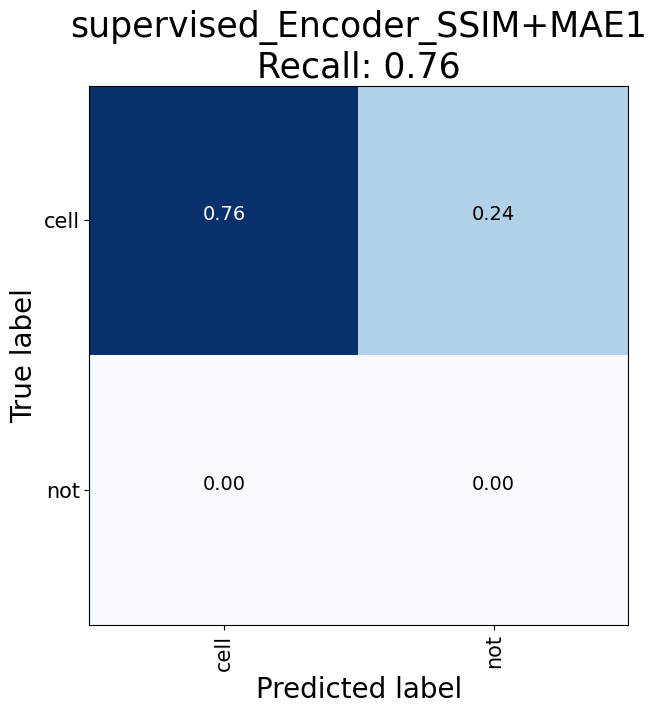

/tmp/ipykernel_48678/2877191624.py:11: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


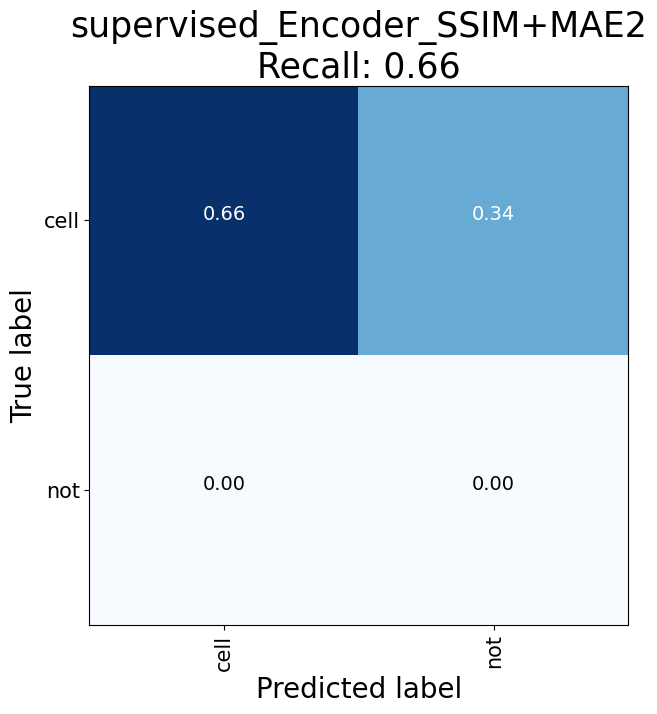

/tmp/ipykernel_48678/2877191624.py:11: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


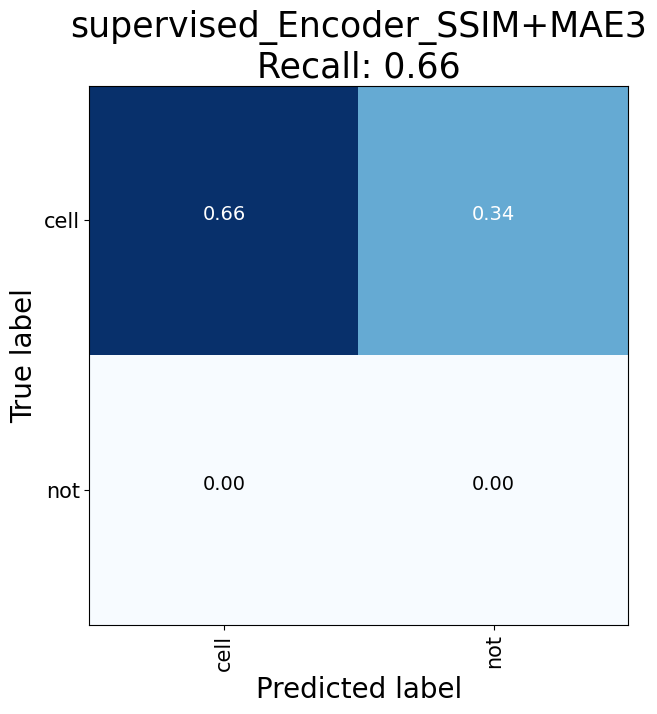

In [12]:
for idx, row in results.iterrows():
    plt.figure(figsize=(7,7))
    plot_confusion_matrix(row.confusion_matrix, classes=['cell', 'not'], title=f"{row.model}\nRecall: {row.recall_score:0.2f}")
    plt.show()